# はじめに
DP-SGDで教師データのプライバシーを保護して、ニューラルネットワークの学習を行います。  
学習は以前の[ノートブック](https://github.com/toshi-4886/privacy_preserving_ML/blob/main/PyTorch/0_baseline.ipynb)をベースにしています。



## 概要
- CIFAR-10を用いたResNet18の学習に、[Opacus](https://opacus.ai/)を用いてDP-SGDを適用する。
- 差分プライバシーを適用した場合のモデルのテスト精度を確認する。


## 参考資料
- Building an Image Classifier with Differential Privacy (Opacus Tutorials)  
https://opacus.ai/tutorials/building_image_classifier
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html


# 実装

## 1. ライブラリのインポート
必要なライブラリをインポートします。

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

!pip install 'opacus>=1.0'
import opacus
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager

import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.9/216.9 KB 6.0 MB/s eta 0:00:00


## 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
Opacusは1.0.0で書き方が大きく変わっているので注意してください。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [2]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
print('Opacus:', opacus.__version__)
!nvidia-smi

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
PyTorch: 1.13.1+cu116
Torchvision: 0.14.1+cu116
Opacus: 1.3.0
Sat Mar 11 01:12:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+---------------

## 3. データセットの用意  



### データセットの取得
カラー画像データセットの[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)を使用します。タスクは10クラス分類です。  
データセットのページからもダウンロードできますが、今回はtorchvisionを使用してデータセットを取得します。

torchvisionでは、データセットに適用する操作をtransformに指定できるので、ニューラルネットワークの学習用の操作を指定しておきます。


教師データとテストデータの両方に下記を適用します。
- ToTensor：データをTensor型に変換
- Normalize：各チャネルの平均が0、標準偏差が1となるように標準化


さらに、教師データには過学習を防止するために、ここでは2種類のdata augmentationを適用します。
- RandomCrop：ランダムに画像を切り抜く
- RandomHorizontalFlip：ランダムに左右反転

In [3]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip()])
)


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### DataLoaderの作成
バッチ学習で利用できるように、DataLoaderを作成します。  
教師データのバッチサイズは一般的な128に設定します。  
学習データでは、バッチ作成時にランダムなデータを選択するためにshuffleをTrueに指定します。


In [4]:
batch_size = 128
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

## 4. ニューラルネットワークの定義  
今回はtorchvisionのResNet18を使用します。  
詳細は下記論文を参照してください。  
[Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)




In [5]:
model = torchvision.models.resnet18()

ResNet18にはBatch Normalizationが使われているため、DP-SGDの学習にはそのまま使うことはできません。  
そこで、ModuleValidatorを使用してGroup Normalizationに置き換えます。

In [6]:
model = ModuleValidator.fix(model)

モデルは使用するデバイスを指定する必要があります。  
GPUを使用する場合は 'cuda' とします。


In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
model = model.to(device)

Using cuda device


## 5. 学習のための設定  
損失はクロスエントロピー、最適化方法は[Adam](https://arxiv.org/abs/1412.6980)を使用します。  
weight_decayは、過学習を防ぐためのパラメータの減衰率です。

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

DP-SGDの学習のための設定も行います。  
ニューラルネットワークのパラメータ$\theta$を下記のように更新します。
$$
\theta_{i+1} \leftarrow \theta_i - \eta \left( \frac{1}{|B|} \sum_{(x,y)\in B} {\rm clip}_C (\nabla_{\theta}\ell(f(x), y)) + Z\right)
$$
ここで、$\ell$は損失関数、${\rm clip}_C$はL2ノルムを$C$に制限する関数、$Z$は多変量正規分布$\mathcal{N}(0,\sigma^2C^2\mathbb{I})$に従うノイズです。  

DP-SGDの学習では、$\sigma$と$C$が指定するパラメータになります。  
今回は、一般的なパラメータ$\sigma=1.0$と$C=1.0$とします。


In [9]:
privacy_engine = opacus.PrivacyEngine()

model, optimizer, train_dataloader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_dataloader,
    noise_multiplier=1.0,
    max_grad_norm=1.0,
)

## 6. 学習




### 学習ループ
学習を50エポック実施します。  
学習結果を確認するために、各エポック終了時にテストデータの損失と精度も計算します。

バッチサイズが大きいとGPUメモリーエラーとなる場合があるので、BatchMemoryManagerを用います。  
学習で消費した$\epsilon$は、privacy_engine.get_epsilonで求めることができます。  
$\epsilon$は、差分プライバシーのパラメータで、値が小さいほどプライバシーが保護されていることになります。  


In [10]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []


for epoch in range(50):
    # training
        
    with BatchMemoryManager(
        data_loader=train_dataloader, 
        max_physical_batch_size=64, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        epoch_loss = []
        pred_list = []
        y_list = []
        model.train()
        for (X, y) in memory_safe_data_loader:
            X, y = X.to(device), y.to(device)

            # optimization step
            optimizer.zero_grad()
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

        train_loss.append(np.mean(epoch_loss))
        train_acc.append(metrics.accuracy_score(y_list, pred_list))

    # calculate epsilon
    epsilon = privacy_engine.get_epsilon(1e-5)
 
    # test
    model.eval()
    epoch_loss = []
    pred_list = []
    y_list = []
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # predict
            pred = model(X)
            loss = criterion(pred, y)

            epoch_loss.append(loss.item())
            y_list.extend(y.to('cpu').numpy().tolist())
            pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

    test_loss.append(np.mean(epoch_loss))
    test_acc.append(metrics.accuracy_score(y_list, pred_list))
    print(f'[Epoch {epoch}] (ε = {epsilon:.2f}, δ = {1e-5}) Train accuracy: {train_acc[-1]:0.2f}, Test accuracy: {test_acc[-1]:0.2f}, Train loss: {train_loss[-1]:0.3f}, Testloss: {test_loss[-1]:0.3f}')

  

[Epoch 0] (ε = 0.29, δ = 1e-05) Train accuracy: 0.19, Test accuracy: 0.25, Train loss: 2.339, Testloss: 2.047
[Epoch 1] (ε = 0.38, δ = 1e-05) Train accuracy: 0.26, Test accuracy: 0.30, Train loss: 2.025, Testloss: 1.938
[Epoch 2] (ε = 0.46, δ = 1e-05) Train accuracy: 0.28, Test accuracy: 0.32, Train loss: 1.981, Testloss: 1.894
[Epoch 3] (ε = 0.53, δ = 1e-05) Train accuracy: 0.30, Test accuracy: 0.34, Train loss: 1.942, Testloss: 1.856
[Epoch 4] (ε = 0.59, δ = 1e-05) Train accuracy: 0.31, Test accuracy: 0.35, Train loss: 1.921, Testloss: 1.828
[Epoch 5] (ε = 0.64, δ = 1e-05) Train accuracy: 0.32, Test accuracy: 0.36, Train loss: 1.891, Testloss: 1.796
[Epoch 6] (ε = 0.69, δ = 1e-05) Train accuracy: 0.33, Test accuracy: 0.36, Train loss: 1.891, Testloss: 1.806
[Epoch 7] (ε = 0.74, δ = 1e-05) Train accuracy: 0.34, Test accuracy: 0.37, Train loss: 1.870, Testloss: 1.762
[Epoch 8] (ε = 0.78, δ = 1e-05) Train accuracy: 0.34, Test accuracy: 0.38, Train loss: 1.870, Testloss: 1.760
[Epoch 9] 

### 学習結果の表示
学習結果として、教師データとテストデータの損失と精度を描画します。

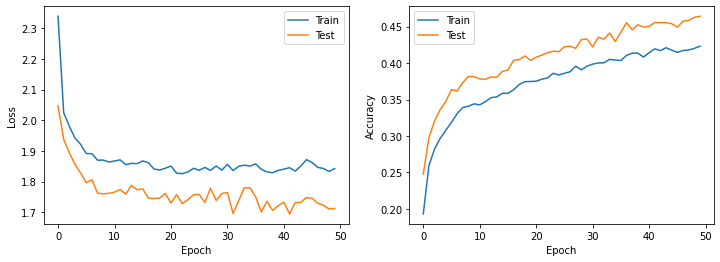

In [11]:

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Train')
plt.plot(test_acc, label='Test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# おわりに


## 今回の結果
今回の設定では、テスト精度は45%となりました。  
差分プライバシーを適用しない場合（85%程度）と比較して大幅に低い値となっています。  
プライバシー保護に関しては、$\epsilon$が2程度となっていて、一般的な保護の度合いとなりました。


## 次にやること
DP-SGDを適用して高いテスト精度を実現する方法を検討したいと思います。